In [1]:
from weldx import Q_
from weldx import MathematicalExpression
from weldx.measurement import MeasurementChain, Error, Signal, SignalSource, SignalTransformation


## Overview

Aquiring experimental data is a process that usually involves multiple substeps. For example, during a temperature measurement we might have a sensor that produces a voltage correlating with the current temperature. If the produced voltage signal is analog, we need to convert it into a digital one to process it on our computer. Since we wanted to know the temperature and not some arbitrary voltage, we also need to transform the voltage data into temperature data by utilizing the calibration of our sensor. 

A quality assesment for a set of experimental data is only possible if we know about the involved substeps and the possible errors they might introduce. As long as we do not have detailed documentation about the measurement procedure, only the persons involved in the experiment have this knowledge.

The `MeasurementChain` class introduced in this tutorial is meant to provide this kind of documentation. We will discuss the different methods to construct a `MeasurementChain` and the features it offers.

## Construction without additional classes

The easiest way to construct a measurement chain is to use the `from_parameters` and the `create_transformation` methods. With these functions, we do not need to bother with as many extra classes as with the other approaches.

We start with the `from_parameters` function to create a new measurement chain. We need to provide 5 parameters to it:

- The name of the measurement chain
- The name of the source that creates the first, unprocessed measurement signal
- The error of the source
- The type of the source signal (analog or digital)
- The unit of the source signal

Optionally, one can also provide the accociated measurement data, if it was recorded, but we will discuss this in a later section. Let's start by creation our first measurement chain:

In [2]:
mc_1 = MeasurementChain.from_parameters(name="Temperature measurement chain 1",
                                        source_name="Thermocouple 1",
                                        source_error=Error(deviation=Q_(0.1, "percent")),
                                        output_signal_type="analog",
                                        output_signal_unit="V",
                                       )

As you can see, we have created a `MeasurementChain` with the name "Temperature measurement chain 1". It's source is named "Thermocouple 1" and it produces an analog output signal in Volts. The specified measurement error is a fixed value of 0.1%. 

Next we want to add the first transformation step, the analog-digital conversion of the signal. Therefore, we use the `create_transformation` method of our newly created measurement chain. As the `from_parameters` function, it accepts the name of the transformation, its error, the output signal and the output unit as parameters. Additionally, we can provide a function that describes how the numerical values and units are transformed.

The output signal type, unit and function are all optional parameters. However, providing none of them wouldn't apply any changes to the signal and emit a warning.

Now we add the AD conversion to our measurement chain:

In [3]:
mc_1.create_transformation(name="AD conversion", 
                           error=None, 
                           output_signal_type="digital", 
                           output_signal_unit=""
                          )

All we needed to specify apart from the name and error was the output signal type as "digital". We also removed the unit by providing an empty string as output unit since the AD conversion just yields a digital number that doesn't necessarily represent a physical quantity. 

Let's add the final transformation, the calibration, which produces the data we are interested in. 

In [4]:
mc_1.create_transformation(name="Calibration",
                           error=Error(Q_(0.4, "percent")),
                           func=MathematicalExpression(expression="a*x+b", 
                                                       parameters={"a": Q_(3, "K"),
                                                                   "b": Q_(273.15, "K")})
                          )

Here we specify a function that describes the transformation of our digital number into an actual temperature value:

$$
3K \cdot x + 273.15K
$$

The name of the variable and the parameters can be arbitrarily chosen. The only restriction is, that the function only has a single variable which represents the input signal. Since the parameters of our function already contain the unit conversion we do not need to provide the `output_signal_unit` parameter. However, we could do this to assure that our output signal has the correct dimensionality. In case the function yields a unit of different dimensionality than passed `output_signal_unit`, an exception would be raised. Be aware, that degrees in Celsius have the same dimensionality (temperature) as Kelvin. So in this case, `create_transformation` wouldn't complain. Additionally, you can't use the `output_signal_unit` parameter to add a unit conversion if the passed function does not contain one. In fact, if only `output_signal_unit` is provided without a function, like in the AD conversion we added before, `create_transformation` generates a corresponding conversion function internally.

## Plotting measurement chains

Now that we have created our first measurement chain without any exceptions, we might want to verify that everything is specified correctly. To do so, we can use pythons `print` command to check all variables, but this would be a bit tedious. A more convinient way is to use the plot function of the `MeasurementChain`.


<AxesSubplot:title={'center':'Temperature measurement chain 1'}>

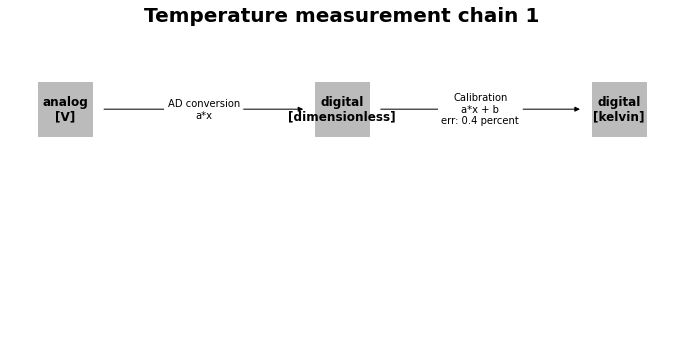

In [5]:
mc_1.plot()

The plot shows us the initial signal produced by the source on the left. To the right of the source signal all transformations and their resulting output signals are shown.

## Construction from dedicated classes

The first method we demonstrated required you to provide a lot of parameters. While this is method is very explicit and doesn't involve many other classes, it is not be the best approach if you wan't to share sources and transformations with other measurement chains or objects. To share information about a source or transformation, two dedicated container classes are available, `SignalSource` and `SignalTransformation`.

A `SignalSource` can be generated as follows:

In [6]:
source_2 = SignalSource(name="Source",
                        error=Error(Q_(0.1,"percent")),
                        output_signal=Signal(signal_type="analog", unit="V")
                       )

The information we provide is similar as before. The only noteworthy thing here is, that the signal type and unit are wrapped into a separate `Signal` class. Now we can use this class to create a measurement chain:    

In [7]:
mc_2 = MeasurementChain(name="Measurement chain 2", 
                        source=source_2)

Next we create a `SignalTransformation` 

In [8]:
transformation_3 = SignalTransformation(name="Transformation",
                                        error=Error(Q_(1,"percent")),
                                        func=MathematicalExpression(expression="a*x+b", 
                                                                    parameters={"a": Q_(3, "K/V"),
                                                                                "b": Q_(273.15, "K")}),
                                        type_transformation="AD"
                                       )

The first three arguments are equivalent as when using the `create_transformation` method. The `type_transformation` parameter expects a string consisting of two letters that can either be "A" for analog and "D" for digital. The first letter is the expected input signal type and the second letter the output signal type.
We can add it to the `MeasurementChain` with the `add_transformation` function.

In [9]:
mc_2.add_transformation(transformation_3)

Here is the corresponding plot:

<AxesSubplot:title={'center':'Measurement chain 2'}>

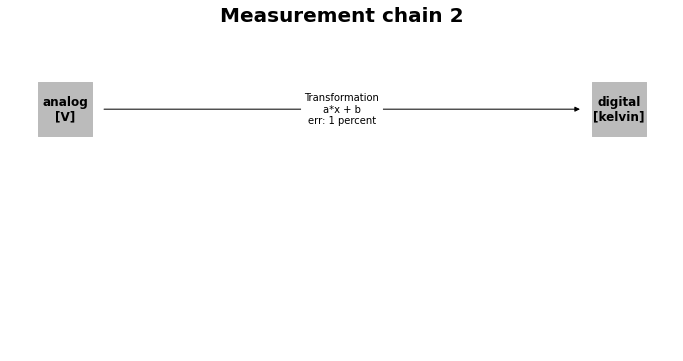

In [10]:
mc_2.plot()

You can get the source and transformation objects of an existing measurement chain with the `source` property and the `get_transformation` function:

In [11]:
mc_2.source

SignalSource(name='Source', output_signal=Signal(signal_type='analog', unit='V', data=None), error=Error(deviation=<Quantity(0.1, 'percent')>))

In [12]:
mc_2.get_transformation("Transformation")

SignalTransformation(name='Transformation', error=Error(deviation=<Quantity(1, 'percent')>), func=<MathematicalExpression>
Expression:
	 a*x + b
Parameters:
	a = 3 kelvin / volt
	b = 273.15 kelvin
, type_transformation='AD', input_shape=None, output_shape=None)

## Construction from equipment classes

The sources and transformations of a measurement chain are often tied to a certain piece of laboratory equipment. The weldx package offers the `GenericEquipment` structure to collect all.. continue